# Test VRP Service 
- This notebook allows experimentation and testing of the VRP Service calls

<span style="color:red; font-weight:bold">Note:</span> Remember to Restart the Notebook **if you have changed code**.<br>The notebook does not auto reload.

In [8]:
# System level imports
import sys
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
TEST_DEV_PRJ_PATH = os.environ.get("TEST_DEV_PRJ_PATH")

# ##### SET SYS PATH TO WHERE THE CODE IS. #####
# Note: Putting our code first in the sys path will make sure it gets picked up
sys.path.insert(0, f"{TEST_DEV_PRJ_PATH}/backend/src")
print(sys.path)

['/Users/dan/Code/Python/Ken/route-optimize/backend/src', '/Users/dan/Code/Python/Ken/route-optimize/backend/src', '/Users/dan/miniforge3/envs/py3.13/lib/python313.zip', '/Users/dan/miniforge3/envs/py3.13/lib/python3.13', '/Users/dan/miniforge3/envs/py3.13/lib/python3.13/lib-dynload', '', '/Users/dan/Code/Python/Ken/route-optimize/.venv/lib/python3.13/site-packages']


In [9]:
# Get the services that we will use
import pandas as pd
from wulfs_routing_api.services.order_services import OrderService
from wulfs_routing_api.models.orders.supabase_order import OrderModel
from wulfs_routing_api.models.customers.supabase_customer import SupabaseCustomer
from wulfs_routing_api.services.customer_service import CustomerService
from wulfs_routing_api.services.vrp_service import VRPService

customer_service = CustomerService(SupabaseCustomer())
order_service = OrderService(OrderModel())
vrp_service = VRPService()

In [10]:
# Things we need to call the solver
number_vehicles=4
depot_coordinates=(42.34902,-71.03118)
orders_df = pd.read_csv("../../data/orders_w_customers.csv")
orders_df.head()

,customer_name_order,order_id,notes,name_key,customer_id,customer_name,address,city,state,zip,location,lon,lat
0,Bar Volpe,NaN,NaN,bar volpe,3.0,Bar Volpe,170 W Broadway,Boston,MA,2127,0101000020E6100000A33F34F364C351C0D354AA9F922B...,-71.053037,42.340412
1,Fox & The Knife,NaN,NaN,fox the knife,4.0,Fox & The Knife,28 West Broadway,South Boston,MA,2127,0101000020E61000009EAB521F6DC351C0C2120F289B2B...,-71.053535,42.340672
2,Dryft Revere,NaN,NaN,dryft revere,7.0,Dryft Revere,500 Ocean Ave,Revere,MA,2151,0101000020E6100000F414DE8A69BF51C065D9DD4D0135...,-70.990817,42.414102
3,Bar Mezzana,NaN,NaN,bar mezzana,13.0,Bar Mezzana,360 Harrison Avenue,Boston,MA,2118,0101000020E6100000FD38509610C451C039D0436D1B2C...,-71.063512,42.344587
4,Black Lamb,NaN,NaN,black lamb,14.0,Black Lamb,571 Tremont Street,Boston,MA,2118,0101000020E610000023A0C211A4C451C05CE7DF2EFB2B...,-71.072514,42.343603


In [11]:
# We crash and burn on calling the solver **solve_vrp**
# Lets test the intermediate function calls

haversine_distance = vrp_service._haversine_distance
# 1️⃣ Same point (distance should be 0)
assert abs(haversine_distance(0, 0, 0, 0)) < 1e-6

# 2️⃣ Approx distance between:
# New York City (40.7128, -74.0060) and London (51.5074, -0.1278)
dist_nyc_london = haversine_distance(40.7128, -74.0060, 51.5074, -0.1278)
print("NYC → London:", dist_nyc_london/1000, "km")
assert 5500*1000 < dist_nyc_london < 5650*1000  # expected ≈ 5570 km

# 3️⃣ San Francisco (37.7749, -122.4194) and Los Angeles (34.0522, -118.2437)
dist_sf_la = haversine_distance(37.7749, -122.4194, 34.0522, -118.2437)
print("SF → LA:", dist_sf_la/1000, "km")
assert 540*1000 < dist_sf_la < 570*1000  # expected ≈ 559 km

# 4️⃣ Paris (48.8566, 2.3522) and Berlin (52.5200, 13.4050)
dist_paris_berlin = haversine_distance(48.8566, 2.3522, 52.5200, 13.4050)
print("Paris → Berlin:", dist_paris_berlin/1000, "km")
assert 875*1000 < dist_paris_berlin < 895*1000  # expected ≈ 878 km

print("✅ All Haversine tests passed!")

NYC → London: 5570.222 km
SF → LA: 559.12 km
Paris → Berlin: 877.463 km
✅ All Haversine tests passed!


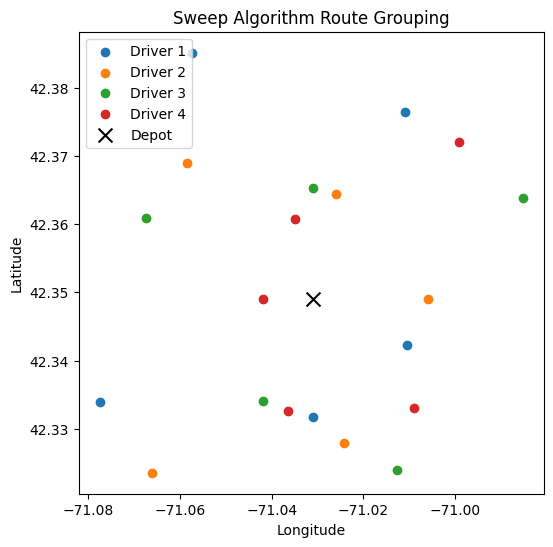

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

split_sweep = vrp_service._split_sweep
# --- Synthetic data ---
np.random.seed(42)
n_points = 20
hq_lat, hq_lon = 42.349, -71.031  # Boston HQ (example)
angles = np.linspace(0, 2*np.pi, n_points, endpoint=False)
radii = np.random.uniform(0.01, 0.05, n_points)

# Create points in a rough circle
lats = hq_lat + radii * np.sin(angles)
lons = hq_lon + radii * np.cos(angles)
df = pd.DataFrame({'lat': lats, 'lon': lons})

# --- Use the sweep split function ---
k = 4
labels = split_sweep(df, k, (hq_lat, hq_lon))

# --- Plot results ---
plt.figure(figsize=(6,6))
for i in range(k):
    group = df[labels == i]
    plt.scatter(group['lon'], group['lat'], label=f'Driver {i+1}')
plt.scatter(hq_lon, hq_lat, color='black', marker='x', s=100, label='Depot')
plt.title('Sweep Algorithm Route Grouping')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [6]:
labels, sequences =vrp_service.solve_vrp(orders_df, num_drivers=number_vehicles, depot_coords=depot_coordinates)

In [7]:
labels

array([1, 0, 1, 2, 1, 0, 3, 2, 1, 0, 0, 0, 0, 3, 2, 3, 3, 3, 1, 0, 3, 1,
       0, 1, 3, 0, 1, 1, 2, 3, 1, 3, 3, 2, 0, 2, 0, 3, 2, 1, 1, 2, 2, 2,
       1, 2, 0, 2, 1, 3, 3, 2, 2, 0, 0, 3, 3, 0, 2, 2, 1, 0, 1, 0, 0, 2,
       3, 1, 3])

In [ ]:
sequences